<a href="https://colab.research.google.com/github/SharonHsu/20210426/blob/main/IoT_Lab2_CNN_0417.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Convolutional Neural Network
在這個Lab中，我們要利用Deep Network來訓練出一個貓狗分類器。


# 資料準備

1. 請下載[data.zip資料集](https://drive.google.com/file/d/1FU8f0ULc3i8uT9CE7bTXTi9tYaKXs4N5/view?usp=sharing)，並將檔案上傳到自己的雲端硬碟
2. 請點選左方的「掛接至雲端硬碟」，並將data.zip拖曳至colab工作階段儲存空間
3. 將data.zip解壓縮



In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
!unzip data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


## 測試圖片檔案是否正確

In [43]:
import glob, os

from PIL import Image
imagepath = 'data/train/cats'
# imagepath = 'data/train/dogs'
imgs_names = glob.glob(os.path.join(imagepath,'*.jpg'))
for imgname in imgs_names: 	
  img = Image.open(imgname) 	
  if img is None:               	
    print(imgname) 

#Import Library
我們載入必要的library：

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
# from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import backend as K
from vis.utils import utils
from keras import activations
#from vis.visualization import visualize_activation, get_num_filters
from vis.input_modifiers import Jitter


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

# Utility Functions
我們以下會用視覺化的工具來幫助各位了解分類的結果。因此在這邊我們這邊先撰寫幾個utility function。函數的名字應該很好了解其功用，因此建議你可以直接看一下其功能後，就往下一個部分前進。

In [15]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    acc = smooth_curve(history.history['accuracy'][:steps])
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])
    
    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()
    
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
 
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

# 參數設定

In [16]:
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'

# Data Generator
Keras針對圖片數量不夠多的問題，也提供了解法：利用ImageDataGenerator

我們可以利用一張圖片，進行若干運算之後，得到不同的圖片。 有興趣的同學可以參考：https://zhuanlan.zhihu.com/p/30197320

In [17]:
# train
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_width, img_height),
    batch_size=20,
    class_mode='categorical')

#　validation
validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = train_datagen.flow_from_directory(
    directory=validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=20,
    class_mode='categorical')


# test
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = train_datagen.flow_from_directory(
    directory=validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=20,
    class_mode='categorical')

FileNotFoundError: ignored

我們可以利用以下的code來看看結果：

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cats/1.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)


i = 0
for batch in datagen.flow(x, batch_size=1,save_to_dir='data/train/cats', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

檢查在data/資料夾下的檔案，會發現這個generator利用了1.jpg產生了很多圖片

# Building a Convolutional Neural Network
在此處，我們要建立一個CNN。

這邊有四個地方是我們沒看過的：

* Conv2D: 這個函數會建立一個convolutional layer。第一個參數為filter數量，第二個是filter size。也可以在此設定padding參數為same (有padding) or valid (沒有padding)。參數Stride預設則為1。
* Activation: 用來單一增加activation function之用。
* MaxPooling2D: 建立一個maxpooling layer。參數為window size。
* Flatten: 將目前的輸出攤平成一個一維向量。
* Dropout: 執行dropout將某些點丟棄，參數為其比率。

以下我們要建立如此的network

1. CONV: 32個filter，每一個filter大小為3x3，activation function為relu
2. POOL: window size為2x2
3. CONV: 32個filter，每一個filter大小為3x3，activation function為relu
4. POOL: window size為2x2
5. CONV: 64個filter，每一個filter大小為3x3，activation function為relu
6. POOL: window size為2x2
7. FC: 64個node的full connected layer
8. Output Layer: 這是一個**[　　]**分類問題，所以output layer的neuron數為:**[　　]**，要用的激活函數為:**[　　]**

注意，在convolution進入到full connected layer的時候，記得要把向量攤平(flatten)。

In [ ]:
# 判斷RGB是在矩陣中的第幾個元素?
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 請填寫下方空白處
# model.add(Dense(  ,activation='     '))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
metrics=['accuracy'])

# Training

在此我們先將epochs設為30次，同學可以自己實驗不同的次數 

In [ ]:
history = model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=1)

# Save

我們可以利用model.save()這個函數，將model存起來供以後使用。

In [ ]:
model.save('model.h5')
save_history(history, 'history.bin')

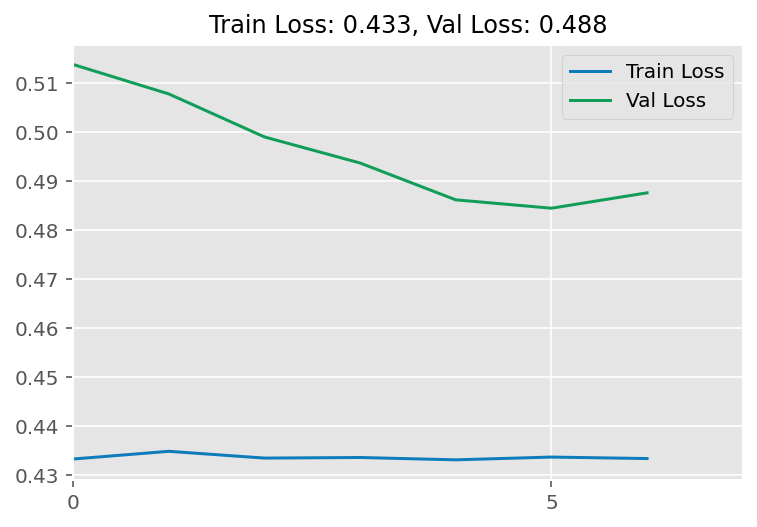

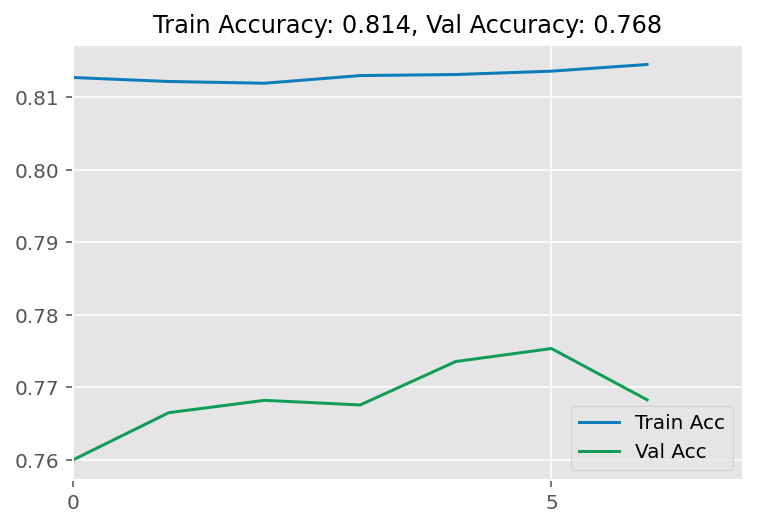

In [ ]:
history = load_history('history.bin')
plot_compare(history)

# Quiz 1: 參數數量
請問我們用手刻的CNN總共的參數數量有幾個？

可以參考：https://keras.io/models/about-keras-models/
提示 summary

In [ ]:
#輸入函數顯示參數數量

# Quiz 2: Prediction
上面我們已經訓練好了一個CNN，接下來請利用訓練出來的CNN來判斷圖片是貓還是狗。

In [ ]:
# input photo
img_path = ''

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)
plt.imshow(img)

In [ ]:
# put your code here
# hint: use "train_generator.class_indices" to confirm the coding of each class

prediction = model.predict(img_tensor)
print(prediction)
prediction = np.argmax(prediction, axis=1)

print(prediction)

if prediction == 0:
    print("It is a cat!")
else:
    print("It is a dog!")

# Quiz 3:
給定testing data為test資料夾中的資料，求出訓練出的model的Accuracy為何。

計算範例：請自行補齊程式
x,y為 不同分類 如 cat or dog


```
total_img=0
correct_img=0
total_img_x=0
correct_img_x=0
total_img_y=0
correct_img_y=0


for x in os.listdir(path='data/test/x'):
  img_path=os.path.join('data/test/x', x)
  img = image.load_img(img_path, target_size=(150, 150))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  prediction = model.predict(img_tensor)
  prediction = np.argmax(prediction, axis=1)
  
  if prediction ==0:
    correct_img=correct_img+1
    correct_img_cat=correct_img_x +1
  total_img=total_img+1
  total_img_x=total_img_x +1
```



In [ ]:


#Put your code here!

#

print("correct_predict_cat: ")
print("total_image_cat: ")
print("prediction accuracy_cat: ")


correct_predict_cat: 50
total_image_cat: 50
prediction accuracy_cat: 1.0
correct_predict_dog: 0
total_image_dog: 50
prediction accuracy_dog: 0.0
correct_predict: 50
total_image: 100
prediction accuracy: 0.5
